In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from Performance import performance_evaluation
perfs = performance_evaluation()

In [2]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,data_generation_process) 
    # print("W_star = ",W_star[0,:])
    np.random.seed(coef_seed)
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}; noise_train_all = {}; noise_test_all = {}
    for iter in iteration_all:
        DataPath_iter = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_iter).mkdir(parents=True, exist_ok=True)
        W_star = data_gen.generate_truth(DataPath_iter,lower, upper, p, d, iter,data_generation_process) 
        # #  ****** Data generation *********
        x_test_all[iter], c_test_all[iter], x_train_all[iter], c_train_all[iter], noise_train_all[iter],noise_test_all[iter],W_star_all[iter] = data_gen.generate_samples(iter,DataPath_iter,p, d, num_test, num_train, alpha, W_star, mis, num_test, 
                                data_generation_process, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, noise_train_all,noise_test_all,W_star_all

In [3]:
def Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process):
    cost_Oracle_with_noise_all = {}; cost_Oracle_wo_noise_all = {}
    for iter in iteration_all:
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            cost_Oracle_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])
            # print("Oracle: iter=",iter,",cost_Oracle_with_noise_all=",np.nanmean(cost_Oracle_with_noise_all[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_Oracle_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],True)
            cost_Oracle_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 10 == 0 and iter >= 0:
            print("Oracle: iter=",iter,",cost_Oracle_with_noise_all=",np.nanmean(cost_Oracle_with_noise_all[iter]))

            # print("Oracle: iter=",iter,",cost_Oracle_with_noise_all=",np.nanmean(cost_Oracle_with_noise_all[iter]),",cost_Oracle_wo_noise_all=",np.nanmean(cost_Oracle_wo_noise_all[iter]))
    return cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all

In [4]:
def Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from OLS import ols_method
    ols_method_obj = ols_method()
    W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
    cost_OLS_with_noise_all = {}; cost_OLS_wo_noise_all = {}
    for iter in iteration_all:
        # compute OLS performance
        W_ols_all[iter], w0_ols_all[iter], t_ols_all[iter], obj_ols_all[iter] = ols_method_obj.ols_solver("",x_train_all[iter], c_train_all[iter])
        cost_dem = (W_ols_all[iter] @ x_test_all[iter].T).T + w0_ols_all[iter]

        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            cost_OLS_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_OLS_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],True)
            cost_OLS_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 10 == 0 and iter >= 0:
            print("OLS: iter=",iter,",cost_OLS_with_noise_all =",np.nanmean(cost_OLS_with_noise_all[iter]))
    return cost_OLS_with_noise_all,cost_OLS_wo_noise_all

In [5]:
def Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from DDR import DDR_method
    ddr_object = DDR_method()
    num_nodes = grid[0] * grid[0]

    w0_ddr_dict = {}; W_ddr_dict = {}
    cost_DDR_with_noise_all = {}; cost_DDR_wo_noise_all = {}
    for iter in iteration_all:
        for mu in mu_all:
            for lamb in lamb_all:
                w0_ddr_dict[iter,mu,lamb],W_ddr_dict[iter,mu,lamb],alpha_rst,obj_ddr = ddr_object.solve_DDR(arcs,lamb,mu,num_nodes,x_train_all[iter],c_train_all[iter])
                cost_pred = (W_ddr_dict[iter,mu,lamb] @ x_test_all[iter].T).T + w0_ddr_dict[iter,mu,lamb]

                if data_generation_process == "SPO_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
                    cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
                    cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])

                if data_generation_process == "DDR_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
                    cost_oracle_pred = (cost_oracle_ori ** mis).T
                    # cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)
                    cost_DDR_wo_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 10 == 0 and iter >= 0:
            print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_with_noise_all =",np.nanmean(cost_DDR_with_noise_all[iter,mu,lamb]))

    return cost_DDR_with_noise_all,cost_DDR_wo_noise_all

In [6]:
def Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process):
    W_EPO_all = {}; w0_EPO_all = {}
    cost_EPO_wo_noise_all = {}; cost_EPO_with_noise_all = {}
    for iter in iteration_all:
        DataPath_seed = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        W_EPO_all[iter],w0_EPO_all[iter] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[iter],c_train_all[iter],arcs)
        
        cost_pred = (W_EPO_all[iter] @ x_test_all[iter].T).T + w0_EPO_all[iter]
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            
            cost_pred = cost_pred[non_negative_cols,:]
            cost_EPO_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_EPO_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
            cost_EPO_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)

        print(method_names[0],": iter=",iter,",cost=",np.nanmean(cost_EPO_with_noise_all[iter]))

    return cost_EPO_with_noise_all,cost_EPO_wo_noise_all

# Parameters

In [2]:
# grid = (5,5) # grid size
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
# d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
# num_nodes = grid[0]*grid[0]
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)

#### Data Generation

In [8]:
grid_all = [(2,2),(3,3),(4,4),(5,5)]
middle_path = '/Data/Shortest_Path_Reproduce/Network_all/'
x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; noise_train_all = {}; noise_test_all = {}; W_star_all = {}
iteration_all = np.arange(0,100)
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]
    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    pathlib.Path(DataPath_parent).mkdir(parents=True, exist_ok=True)
    print("DataPath_parent:", DataPath_parent)
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    x_test_all[grid[0]], c_test_all[grid[0]], x_train_all[grid[0]], c_train_all[grid[0]],noise_train_all[grid[0]],noise_test_all[grid[0]],W_star_all[grid[0]] \
    = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    with open(DataPath+'x_test_all.pkl', "wb") as tf:
        pickle.dump(x_test_all[grid[0]],tf)
    with open(DataPath+'c_test_all.pkl', "wb") as tf:
        pickle.dump(c_test_all[grid[0]],tf)
    with open(DataPath+'x_train_all.pkl', "wb") as tf:
        pickle.dump(x_train_all[grid[0]],tf)
    with open(DataPath+'c_train_all.pkl', "wb") as tf:
        pickle.dump(c_train_all[grid[0]],tf)
    with open(DataPath+'noise_train_all.pkl', "wb") as tf:
        pickle.dump(noise_test_all[grid[0]],tf)
    with open(DataPath+'noise_train_all.pkl', "wb") as tf:
        pickle.dump(noise_test_all[grid[0]],tf)
    with open(DataPath+'W_star_all.pkl', "wb") as tf:
        pickle.dump(W_star_all[grid[0]],tf)

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/2by2_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/3by3_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/4by4_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/5by5_grid_SPO_Data_Generation_S=100/


### Oracle

In [9]:
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]
    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"

    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)
    cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all \
        = Implement_Oracle(arcs, grid,mis,bump,W_star_all[grid[0]],x_test_all[grid[0]],noise_test_all[grid[0]],iteration_all,num_feat,data_generation_process)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_with_noise_all,tf)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-14
Oracle: iter= 0 ,cost_Oracle_with_noise_all= 7.518113970776958
Oracle: iter= 10 ,cost_Oracle_with_noise_all= 7.714351381287567
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.657783242002904
Oracle: iter= 30 ,cost_Oracle_with_noise_all= 7.599347831334145
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.787269966292056
Oracle: iter= 50 ,cost_Oracle_with_noise_all= 7.451293271575745
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.749552907108204
Oracle: iter= 70 ,cost_Oracle_with_noise_all= 7.661290587501351
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.599788287866947
Oracle: iter= 90 ,cost_Oracle_with_noise_all= 7.626130662932813
Oracle: iter= 0 ,cost_Oracle_with_noise_all= 15.000977310409718
Oracle: iter= 10 ,cost_Oracle_with_noise_all= 14.734942034360087
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 15.147329996892488
Oracle: iter= 30 ,cost_Oracle_with_noise_all= 14.854494267475612
Oracle: ite

### OLS

In [10]:
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]

    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"

    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)
    cost_OLS_with_noise_all,cost_OLS_wo_noise_all \
        = Implement_OLS(arcs, grid,mis,bump,W_star_all[grid[0]],x_test_all[grid[0]],noise_test_all[grid[0]],x_train_all[grid[0]],c_train_all[grid[0]],iteration_all,num_feat,data_generation_process)
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_with_noise_all,tf)

OLS: iter= 0 ,cost_OLS_with_noise_all = 7.572913363495361
OLS: iter= 10 ,cost_OLS_with_noise_all = 7.73359024637193
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.668219451633791
OLS: iter= 30 ,cost_OLS_with_noise_all = 7.66757081630409
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.8642940597864985
OLS: iter= 50 ,cost_OLS_with_noise_all = 7.500253720806246
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.81155404376656
OLS: iter= 70 ,cost_OLS_with_noise_all = 7.817993292509578
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.6195403980723695
OLS: iter= 90 ,cost_OLS_with_noise_all = 7.685580256506786
OLS: iter= 0 ,cost_OLS_with_noise_all = 15.11246936115915
OLS: iter= 10 ,cost_OLS_with_noise_all = 14.892850337386385
OLS: iter= 20 ,cost_OLS_with_noise_all = 15.313933616637385
OLS: iter= 30 ,cost_OLS_with_noise_all = 14.974973132592766
OLS: iter= 40 ,cost_OLS_with_noise_all = 14.685791916456248
OLS: iter= 50 ,cost_OLS_with_noise_all = 15.160166402869955
OLS: iter= 60 ,cost_OLS_with_noise_all = 15.1495221658

### DDR

In [11]:
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]

    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"

    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)
    
    mu_all = np.round(np.arange(0.1,1.0,0.1),4)
    lamb_all = np.round(np.arange(0.0,1.0,0.1),4)
    cost_DDR_with_noise_all,cost_DDR_wo_noise_all \
        = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,\
                        bump,W_star_all[grid[0]],x_test_all[grid[0]],noise_test_all[grid[0]],x_train_all[grid[0]],c_train_all[grid[0]],\
                            iteration_all,num_feat,data_generation_process)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_with_noise_all,tf)

DDR: iter= 0 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.570879237548399
DDR: iter= 10 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.733049244910601
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.668782922600514
DDR: iter= 30 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.666348504252206
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.860506930015548
DDR: iter= 50 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.49916150370262
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.812285585977034
DDR: iter= 70 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.821552273593068
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.6197175913772925
DDR: iter= 90 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 7.686569735658682
DDR: iter= 0 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 15.110179774058114
DDR: iter= 10 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noise_all = 14.892542888570585
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_with_noi

### EPO

In [12]:
from PYEPO import PyEPO_Method
epo_runner = PyEPO_Method()
method_names = ["spo+"]
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]

    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"

    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)
    batch_size = 20
    num_epochs = 1000
    cost_SPO_with_noise_all,cost_SPO_wo_noise_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                                  W_star_all[grid[0]],bump,x_train_all[grid[0]],c_train_all[grid[0]],x_test_all[grid[0]],noise_test_all[grid[0]],\
                    arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)
    with open(DataPath+'cost_SPO_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_with_noise_all,tf)

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8378.05it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.780944010223618
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3939.68it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.009010723630045
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3858.18it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.9785164408696
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3730.53it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 8.140531306471695
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3779.88it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 8.157452108930372
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3832.02it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.256205017146108
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3467.86it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 8.343002095301642
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3779.71it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.132648285667994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3866.22it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 8.11968107663187
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3603.23it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.046313260917369
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4005.94it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.788811356999034
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3976.59it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.85067878422508
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3777.29it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.182586958995936
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3750.64it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.339787336409252
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3962.27it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.902971816190651
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3953.83it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 8.016878046401416
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4075.94it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.003183157228612
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3575.86it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.828885102517822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3627.51it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.886980144148956
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3691.10it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 8.336445694932893
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3489.64it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.064151803225316
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3630.55it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.125697199033505
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3655.39it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.813990968571867
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4050.71it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 8.08567447479011
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3634.48it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.997333127644348
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3433.00it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.138614360910404
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3827.02it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.970173002705755
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3324.70it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 8.058343593056934
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3900.92it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.8434790876675775
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3599.55it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.134508244976123
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3636.09it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.171286587612204
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3933.11it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 8.072077122629539
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3822.18it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.235841073531104
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4003.19it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.74707849043608
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3691.39it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.157701539614687
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3750.24it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.933857537052346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3736.51it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.807027096204368
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3516.47it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 8.035120854073758
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3836.58it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.796860236458184
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3560.86it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.248427229787602
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3684.06it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.14989454470956
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3731.92it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.748137637493105
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4044.14it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 8.267254783431309
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3856.83it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.468417219084325
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3759.25it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 8.254596052016266
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3990.74it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 8.118655860812247
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4079.78it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.973172589025458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3692.20it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.948636235322654
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3875.50it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 8.074804010897154
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4145.27it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 8.16402514865089
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3634.52it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.937537314107233
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3761.67it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.03924520652904
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3950.96it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.899445867315694
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3934.84it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.803713558009135
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3732.75it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 8.092939854997555
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3946.61it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.0895057615501
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3579.61it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.9096973889329165
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3982.32it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.224768617251614
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3589.38it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.940972370764428
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4059.72it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.344486306713035
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4135.95it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.8864438440016675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3726.35it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.666011247987775
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3644.69it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.957185246500549
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3869.39it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.8486172721984095
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3607.51it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 8.20063749916971
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3745.32it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.795784196872317
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3978.47it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.875870869668345
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4072.65it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.88952180987267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3707.41it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.790399634025855
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4085.47it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.696266805443935
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4098.72it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.81142875310971
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3965.42it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.036550258179044
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3878.41it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.277956317908238
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3875.36it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.998003917400079
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3518.50it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.036009739069083
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3749.50it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.068341667306347
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3783.42it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.105604512439308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3774.91it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.823376688547008
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3632.50it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.001747637187957
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3942.27it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.321786718522613
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3886.82it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.128600596989255
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4141.99it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.99699634529035
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3852.97it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.868745975900422
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3933.44it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.775799803490745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4140.93it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 8.020472439641255
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3648.33it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 8.106206909940612
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3846.47it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.939831557305908
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4157.63it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 8.08227561881259
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3639.40it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.850089492514224
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4000.33it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.218793230223856
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3689.77it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.33916020559604
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3786.02it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.101405909681082
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3972.03it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 8.022760860749738
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3953.98it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 8.175238986422189
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4091.80it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.719387337330372
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4295.11it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.843897314276904
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3820.44it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.893990280013146
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3691.13it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.8667325333199605
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3671.61it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.949778538593586
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3968.38it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.905422680093449
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2321.16it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 15.975522931044809
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2316.68it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 16.31716134108101
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2198.66it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 16.33341520266166
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2139.78it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 16.038896753447318
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2371.69it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 15.804793137506818
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2173.82it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 15.973593578908996
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2291.01it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 15.797603570094779
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2329.42it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 15.560019845346158
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2220.01it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 15.800668313030735
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2321.66it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 15.884835582468238
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2167.35it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 15.867685211182039
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2261.63it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 16.06551837041192
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2346.36it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 16.31300267946625
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2224.60it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 15.583612990509023
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2309.63it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 15.982261946521241
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2265.42it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 16.330852587121708
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2347.26it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 15.559930190410357
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2259.58it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 15.582582065864008
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2342.64it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 15.379654377982309
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2436.65it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 15.64982987220326
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2249.32it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 16.271785963428144
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2337.55it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 15.535491180318214
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2300.82it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 16.20045463889953
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2321.75it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 15.568016097406627
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2368.61it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 15.33416098365446
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2274.28it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 15.905582964252666
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2334.15it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 16.233534657001506
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2334.42it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 15.584012508856157
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2347.37it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 16.17057408385362
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2227.87it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 15.96487969634995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2381.18it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 15.926150718445264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2299.58it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 16.01859962991398
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2425.53it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 16.33419815951567
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2195.30it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 15.83647941085458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2292.41it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 15.62606934487867
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2264.54it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 16.28338590678323
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2303.46it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 16.12973480325168
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2324.77it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 16.002529440223793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2231.10it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 16.517805726659343
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2280.55it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 15.781709293975968
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2253.97it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 15.85571255826925
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2337.55it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 16.31938780527137
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2250.88it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 15.880061197295111
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2454.19it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 16.26419342876126
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2236.44it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 15.839983663390042
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2348.53it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 15.798516225707106
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2213.22it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 15.965152047441071
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2331.20it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 16.11737492408888
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2343.46it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 15.875353626745229
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2230.47it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 15.456742148209132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2230.24it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 16.188006662366796
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2244.73it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 16.341615858038754
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2252.86it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 15.781600499069041
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2433.09it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 15.922472026049848
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2434.88it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 15.762011198660598
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2298.63it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 16.177040820389475
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2227.47it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 15.419922351543162
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2303.18it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 16.5208278182522
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2251.25it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 16.12538995913045
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2178.46it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 16.065478378313358
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2284.31it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 15.64263835144945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2458.98it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 15.702104153274588
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2342.13it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 16.61520422167734
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2339.83it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 15.957169680218797
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2242.55it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 16.024253188436255
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2212.78it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 15.449834873790936
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2241.66it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 15.780869511425236
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2171.22it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 16.30282018204713
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2390.18it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 15.55356760477281
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2358.48it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 16.00025476225702
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2205.71it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 15.712913564597232
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2215.93it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 15.91693868899255
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2273.87it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 16.47078967218031
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2355.60it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 15.577469187099908
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2237.13it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 16.367372856782794
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2285.09it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 15.87664404122465
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2321.76it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 16.326679323775274
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2412.79it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 15.818857777202208
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2341.75it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 15.88779663543999
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2219.87it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 16.590101183022174
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2290.15it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 15.869301103501002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2234.44it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 15.829499604725015
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2331.70it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 16.244817682915283
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2238.10it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 15.80094536320195
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2360.33it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 16.54556342973654
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2281.17it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 15.691618666762198
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2123.87it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 15.733678769406353
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2227.38it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 16.31597591036497
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2332.73it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 15.824365550617884
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2135.93it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 15.705912358424458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2444.86it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 15.809139804451961
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2427.65it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 15.955089155470024
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2220.45it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 16.047674651587982
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2298.27it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 16.0855660632903
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2315.20it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 15.945558055061545
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2251.81it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 15.936666568171383
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2383.28it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 16.113439038326593
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2356.20it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 15.329333350069982
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2301.12it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 15.74068337042948
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2412.42it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 16.08656497070995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1563.60it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 22.949289668206337
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1678.55it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 23.780883705798658
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1566.10it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 22.9131345250235
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1617.29it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 23.652858174770433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1580.30it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 24.354448841520227
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1630.82it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 24.10399776240939
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1623.79it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 24.220059161922865
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1530.92it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 24.229872953760655
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1560.82it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 23.08206083026062
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1636.23it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 23.72738790947038
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1574.36it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 23.906870520863453
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1539.62it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 23.8591638650777
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1576.11it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 23.635170083609964
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1626.60it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 23.970110276706823
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1547.87it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 23.968829961961216
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1537.11it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 23.796864784270433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1559.84it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 23.15890985542096
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1622.25it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 23.53683030467643
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1626.49it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 24.000601245072033
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1680.13it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 24.080374586576493
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1630.50it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 23.55422947549686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1575.65it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 24.1236473263745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1629.72it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 23.501645470557254
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1546.74it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 23.818913004129186
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1583.78it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 23.331820282326554
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1586.37it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 23.45159647669179
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1588.21it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 23.920260944065223
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1626.87it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 23.451475709662844
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1607.43it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 22.99742589894341
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1605.01it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 23.836141814198427
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1611.81it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 23.82832786870659
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1594.05it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 24.011935146501635
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1623.06it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 22.997123951324145
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1610.31it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 23.407478725818603
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1609.19it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 23.685059226118195
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1556.35it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 22.803111244010584
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1585.69it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 22.818752348542994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1583.01it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 23.729623049378105
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1601.04it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 23.722311962870684
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1608.29it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 23.683143383269712
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1542.86it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 24.099849542078413
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1573.51it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 23.242699417126502
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1594.56it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 23.67862121277481
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1563.25it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 23.641377697347195
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1638.64it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 23.47000822587449
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1579.85it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 23.869761622853346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1640.28it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 23.964976929625628
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1568.19it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 24.649418522717525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1535.60it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 23.032345528895124
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1601.05it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 24.361549618487043
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1531.16it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 23.821053029134582
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1586.62it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 23.718401771727244
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1536.69it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 23.69079029159928
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1652.40it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 24.134326374795023
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1541.07it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 23.50573185722943
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1591.04it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 23.42140734391761
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1586.57it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 23.727353438975943
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1641.44it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 23.571825612671155
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1574.37it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 23.99092474773907
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1615.70it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 23.691680431077252
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1609.24it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 23.324732697921178
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1586.97it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 24.161901129970442
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1579.08it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 23.474344707495984
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1575.51it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 23.878622909290527
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1595.84it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 23.98264521563699
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1678.49it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 22.895051767285782
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1511.50it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 23.623764669476984
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1662.59it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 23.75155319643116
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1587.37it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 23.263970287845897
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1583.78it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 24.13525985348131
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1639.83it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 24.553138171361656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1554.61it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 24.05622588520479
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1613.90it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 23.990837412739122
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1619.12it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 23.564524178750247
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1674.43it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 23.796822205067976
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1647.91it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 23.04665179746282
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1610.28it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 23.933024655485976
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1577.49it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 23.492661350749145
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1593.42it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 24.08729377317802
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1551.30it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 24.440849453382
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1591.68it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 23.655733727372382
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1591.72it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 23.62437630359078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1609.30it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 23.290083372962414
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1518.28it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 23.90371081480726
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1531.30it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 23.467992393976537
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1613.50it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 23.507724089041425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1609.25it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 23.61922560811982
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1626.17it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 23.410024162027614
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1528.26it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 23.503879356944502
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1665.00it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 23.7890679776934
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1537.73it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 24.352298215650972
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1544.16it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 23.837598985123492
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1541.79it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 23.4781043526878
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1581.20it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 23.74846512093915
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1640.71it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 23.354273110055566
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1529.94it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 24.048532860873305
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 2447.30it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 23.24288668726608
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1524.51it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 23.197411164983492
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1626.68it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 23.42232823927912
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1673.67it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 24.14325369210561
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1238.94it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 30.868107177694466
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1237.53it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 30.50998345538852
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1221.08it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 31.289542963473796
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1212.21it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 30.837512987568694
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1212.77it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 30.856937249084293
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1177.05it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 32.11598786105914
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1252.14it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 30.800138281027717
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1210.86it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 30.793656171474634
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1211.99it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 31.612716030786054
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1230.67it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 31.579492054439964
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1173.78it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 31.764147818845988
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1178.33it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 31.669779321444363
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1227.31it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 31.81840696014381
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1220.15it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 30.73059317937164
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1193.91it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 30.441855149594574
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1160.40it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 31.46909658373647
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1198.50it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 31.129446392819176
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1246.85it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 31.5101584796807
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1172.74it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 31.98423981644869
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1217.17it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 31.630026692341154
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1234.36it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 31.48658679097284
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1242.47it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 30.225684570563182
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1188.22it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 31.942468079228956
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1198.78it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 31.632096185311674
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1201.67it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 30.76225378993654
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1198.19it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 32.08430321931019
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1225.63it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 31.82370006504007
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1212.10it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 31.196895997845655
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1234.37it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 30.362219990796593
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1229.42it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 31.20202366755533
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1204.20it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 31.572185666995182
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1191.13it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 31.988258955468353
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1225.12it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 31.43584587415157
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1500.87it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 32.171220852387435
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1248.81it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 31.667170029421897
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1240.13it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 31.85713683149796
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1252.00it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 31.662395304424525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1218.96it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 31.23856683676192
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1263.65it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 31.085797876816216
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1251.66it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 30.872290441921315
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1262.58it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 31.69359929039171
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1244.74it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 32.25403831529031
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1247.60it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 30.82185642963211
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1250.66it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 31.08765569067092
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1234.16it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 32.20769755083795
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1210.76it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 30.907143363943433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1162.28it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 30.77432439251027
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1242.07it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 32.41820267705102
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1231.35it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 30.82299346516241
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1228.77it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 31.607051525815173
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1198.74it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 31.47402774901001
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1208.37it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 31.44537626265562
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1179.83it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 30.879915021099382
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1255.43it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 31.59366991341264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1205.90it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 30.29404465094656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1223.36it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 31.486445931468896
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1224.14it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 31.737257024164073
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1194.83it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 32.115906510200425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1226.78it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 30.901758401338842
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1200.86it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 31.743768956704844
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1196.07it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 31.283588475867205
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1203.35it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 31.963900712720264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1195.72it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 31.523938350000563
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1211.68it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 32.11662034819406
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1228.06it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 31.39752790115387
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1210.78it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 32.208422629449366
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1219.78it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 32.02756978132467
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1201.57it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 31.467516397637464
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1235.79it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 31.42854228099164
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1201.22it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 31.3911651862597
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1287.71it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 31.636932526013236
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1215.17it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 30.477776333026764
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1218.69it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 31.484343622929302
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1199.95it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 31.290208306155176
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1187.80it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 32.34451304603981
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1219.23it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 31.186387263175632
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1167.17it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 31.110852975938155
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1189.87it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 31.082282639948126
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1173.06it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 32.292828182761326
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1228.67it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 32.025049694232926
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1329.68it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 30.856921188969388
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1211.03it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 31.864225493161353
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1215.92it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 31.169612393480907
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1193.92it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 31.370011592463815
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1171.32it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 31.952392272250282
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1244.17it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 31.036881751700165
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1185.72it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 31.55195148452626
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1166.21it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 30.93599451137938
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1198.17it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 31.68111071738471
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1247.26it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 30.811120688871817
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1216.83it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 30.533290749910122
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1218.89it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 32.37318403742455
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1309.26it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 31.384561740729534
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1220.72it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 30.45272568226229
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1214.24it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 31.017893596590582
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1194.73it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 30.326298284396778
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1202.40it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 30.982544830115884
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1206.64it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 30.66375823561295
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1202.44it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 32.07761447254557
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1231.19it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 31.94186337395903


## DDR vs OLS Comparison

In [65]:
def cross_compare2plus(c_item, c_base, c_oracle):
    N = len(c_item)
    c_diff = c_base - c_item
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff > 0) # indicate num of c_item is lower than c_base
    lose = np.sum(c_diff < 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
#     print(N, equals, wins, lose)
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    cost_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base))
    regret_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base) - np.mean(c_oracle))
    return win_ratio, cost_reduction, regret_reduction

In [66]:
iteration_all = np.arange(0,100) 
h2h_ddr_vs_ols_all = {}; cost_reduction_ddr_vs_ols_all = {}; regret_reduction_ddr_vs_ols_all = {}
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]

    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    pathlib.Path(DataPath_parent).mkdir(parents=True, exist_ok=True)
    print("DataPath_parent:", DataPath_parent)
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    # iteration_all = np.arange(0,20)

    with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
        cost_OLS_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)


    h2h_ddr_vs_ols_avg = np.zeros((len(mu_all),len(lamb_all))); regret_ddr_vs_ols_avg = np.zeros((len(mu_all),len(lamb_all)))
    h2h_ddr_vs_ols_perc = np.zeros((len(mu_all),len(lamb_all))); regret_ddr_vs_ols_perc = np.zeros((len(mu_all),len(lamb_all)))

    mu_index = 0
    for mu in mu_all:
        lamb_index = 0
        for lamb in lamb_all:
            h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
            for iter_index in range(len(iteration_all)):
                iter = iteration_all[iter_index]
                h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
            h2h_ddr_vs_ols_avg[mu_index,lamb_index] = np.nanmean(h2h_ddr_ols)
            regret_ddr_vs_ols_avg[mu_index,lamb_index] = np.nanmean(regret_reduction_ddr_vs_ols)
            regret_ddr_vs_ols_perc[mu_index,lamb_index] = len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols)
            h2h_ddr_vs_ols_perc[mu_index,lamb_index] = len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols)
            # print("mu=",mu,",lamb=",lamb,"h2h_ddr_ols=",np.nanmean(h2h_ddr_ols),"regret=",np.nanmean(regret_reduction_ddr_vs_ols))
            lamb_index = lamb_index + 1

            h2h_ddr_vs_ols_all[grid[0],mu,lamb] = h2h_ddr_ols
            cost_reduction_ddr_vs_ols_all[grid[0],mu,lamb] = cost_reduction_ddr_vs_ols
            regret_reduction_ddr_vs_ols_all[grid[0],mu,lamb] = regret_reduction_ddr_vs_ols
        mu_index = mu_index + 1
    regret_DDR_vs_OLS_para_avg_df = pd.DataFrame(regret_ddr_vs_ols_avg)
    regret_DDR_vs_OLS_para_avg_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    regret_DDR_vs_OLS_para_avg_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    regret_DDR_vs_OLS_para_avg_df.to_csv(DataPath+"regret_ddr_vs_ols_avg.csv")

    h2h_DDR_vs_OLS_para_avg_df = pd.DataFrame(h2h_ddr_vs_ols_avg)
    h2h_DDR_vs_OLS_para_avg_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    h2h_DDR_vs_OLS_para_avg_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    h2h_DDR_vs_OLS_para_avg_df.to_csv(DataPath+"h2h_ddr_vs_ols_avg.csv")

    regret_ddr_vs_ols_perc_df = pd.DataFrame(regret_ddr_vs_ols_perc)
    regret_ddr_vs_ols_perc_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    regret_ddr_vs_ols_perc_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    regret_ddr_vs_ols_perc_df.to_csv(DataPath+"regret_ddr_vs_ols_perc.csv")

    h2h_ddr_vs_ols_perc_df = pd.DataFrame(h2h_ddr_vs_ols_perc)
    h2h_ddr_vs_ols_perc_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    h2h_ddr_vs_ols_perc_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    h2h_ddr_vs_ols_perc_df.to_csv(DataPath+"h2h_ddr_vs_ols_perc.csv")

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/2by2_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/3by3_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/4by4_grid_SPO_Data_Generation_S=100/
DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Network_all/5by5_grid_SPO_Data_Generation_S=100/


### * Impact of network

In [39]:
grid_all = [(2,2),(3,3),(4,4),(5,5)]
mu_all = np.round(np.arange(0.1,1.0,0.1),4)
lamb_all = np.round(np.arange(0.0,1.0,0.1),4)
middle_path = '/Data/Shortest_Path_Reproduce/Network_all/'
avg_max_arr = np.zeros(len(grid_all)); avg_opt_para = {}
pert_max_arr = np.zeros(len(grid_all)); pert_opt_para = {}
grid_index = 0
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]
    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    regret_ddr_vs_ols_avg = pd.read_csv(DataPath+"regret_ddr_vs_ols_avg.csv").values[:,1:len(lamb_all)+1].astype(float)
    avg_max_arr[grid_index] = np.max(regret_ddr_vs_ols_avg) * 100
    max_index = np.unravel_index(np.argmax(regret_ddr_vs_ols_avg), regret_ddr_vs_ols_avg.shape)
    avg_opt_para[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    regret_ddr_vs_ols_perc = pd.read_csv(DataPath+"regret_ddr_vs_ols_perc.csv").values[:,1:len(lamb_all)+1].astype(float)
    pert_max_arr[grid_index] = np.max(regret_ddr_vs_ols_perc)
    max_index = np.unravel_index(np.argmax(regret_ddr_vs_ols_perc), regret_ddr_vs_ols_perc.shape)
    pert_opt_para[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    grid_index = grid_index + 1

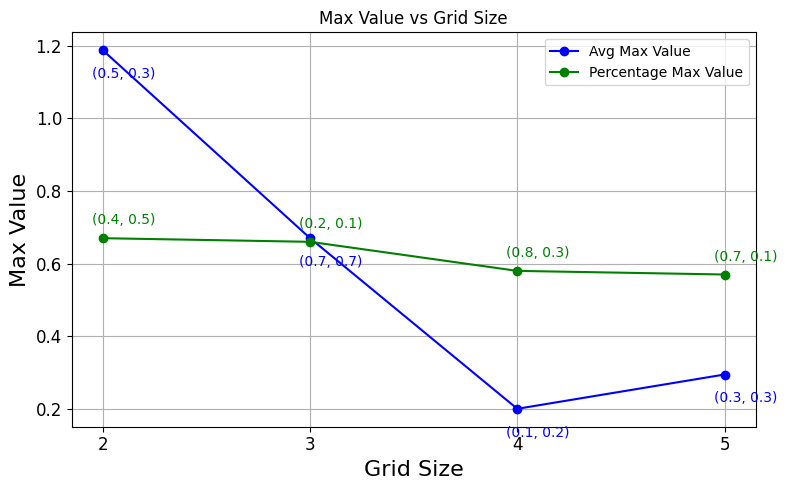

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# 数据
grid_all = [(2,2), (3,3), (4,4), (5,5)]
# 横坐标只取网格边长
grid_sizes = [g[0] for g in grid_all]
# 绘图
plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, avg_max_arr, marker='o', linestyle='-', color='b', label='Avg Max Value')
plt.plot(grid_sizes, pert_max_arr, marker='o', linestyle='-', color='g', label='Percentage Max Value')
# 添加注释
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = avg_opt_para[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, avg_max_arr[i]),
                 textcoords="offset points",
                 xytext=(15, -20),  # 注释位置偏移
                 ha='center',
                 fontsize=10,
                 color = "blue")

# 添加注释
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = pert_opt_para[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, pert_max_arr[i]),
                 textcoords="offset points",
                 xytext=(15, 10),  # 注释位置偏移
                 ha='center',
                 fontsize=10,
                 color = "green")
    
# 坐标轴和标题
plt.xlabel("Grid Size",fontsize = 16)
plt.ylabel("Max Value",fontsize = 16)
plt.title("Max Value vs Grid Size")
plt.xticks(grid_sizes,fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.dirname(grandparent_directory) + middle_path +"Impact_Network_Structure.pdf", format='pdf')
plt.show()

### * H2H_regret

In [71]:
from Figures import regret_and_h2h_figure
rhf = regret_and_h2h_figure()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


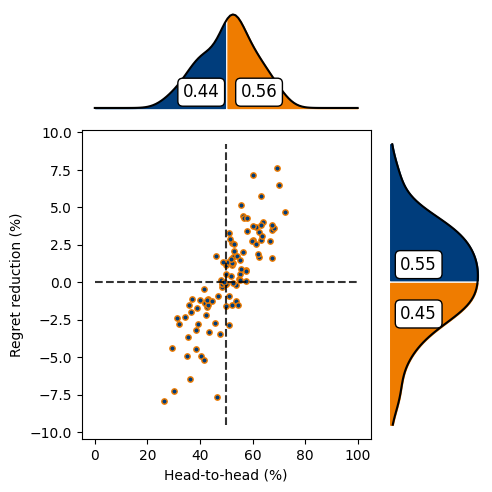

In [103]:
grid = (5,5)
mu = 0.3
lamb = 0.3
file_name = os.path.dirname(grandparent_directory) + middle_path +"DDR_vs_OLS_H2H_Regret_"+str(grid[0])+"times"+str(grid[1])+"_mu="+str(mu)+"_lamb="+str(lamb)
rhf.figure_plot_upright(h2h_ddr_vs_ols_all[grid[0],mu,lamb]*100,regret_reduction_ddr_vs_ols_all[grid[0],mu,lamb]*100,file_name,\
                        size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                        ysame = 0, yrange = [6,6], sublabel = '', ypio = 1)

## DDR vs SPO

In [85]:
iteration_all = np.arange(0,100) 
h2h_ddr_vs_spo_all = {}; cost_reduction_ddr_vs_spo_all = {}; regret_reduction_ddr_vs_spo_all = {}
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
    num_nodes = grid[0]*grid[0]
    DataPath_parent = os.path.dirname(grandparent_directory) + middle_path +str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_S=100/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"

    with open(DataPath+'cost_SPO_with_noise_all.pkl', "rb") as tf:
        cost_SPO_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)

    h2h_ddr_vs_spo_avg = np.zeros((len(mu_all),len(lamb_all))); regret_ddr_vs_spo_avg = np.zeros((len(mu_all),len(lamb_all)))
    h2h_ddr_vs_spo_perc = np.zeros((len(mu_all),len(lamb_all))); regret_ddr_vs_spo_perc = np.zeros((len(mu_all),len(lamb_all)))

    mu_index = 0
    for mu in mu_all:
        lamb_index = 0
        for lamb in lamb_all:
            h2h_ddr_spo = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_spo = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_spo = np.zeros(len(iteration_all))
            for iter_index in range(len(iteration_all)):
                iter = iteration_all[iter_index]
                h2h_ddr_spo[iter_index],cost_reduction_ddr_vs_spo[iter_index],regret_reduction_ddr_vs_spo[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_SPO_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
            h2h_ddr_vs_spo_avg[mu_index,lamb_index] = np.nanmean(h2h_ddr_spo)
            regret_ddr_vs_spo_avg[mu_index,lamb_index] = np.nanmean(regret_reduction_ddr_vs_spo)
            regret_ddr_vs_spo_perc[mu_index,lamb_index] = len(regret_reduction_ddr_vs_spo[regret_reduction_ddr_vs_spo > 0.0])/len(regret_reduction_ddr_vs_spo)
            h2h_ddr_vs_spo_perc[mu_index,lamb_index] = len(h2h_ddr_spo[h2h_ddr_ols >= 0.5])/len(h2h_ddr_spo)
            # print("mu=",mu,",lamb=",lamb,"h2h_ddr_ols=",np.nanmean(h2h_ddr_ols),"regret=",np.nanmean(regret_reduction_ddr_vs_ols))
            lamb_index = lamb_index + 1

            h2h_ddr_vs_spo_all[grid[0],mu,lamb] = h2h_ddr_spo
            cost_reduction_ddr_vs_spo_all[grid[0],mu,lamb] = cost_reduction_ddr_vs_spo
            regret_reduction_ddr_vs_spo_all[grid[0],mu,lamb] = regret_reduction_ddr_vs_spo
        mu_index = mu_index + 1
    regret_DDR_vs_SPO_para_avg_df = pd.DataFrame(regret_ddr_vs_spo_avg)
    regret_DDR_vs_SPO_para_avg_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    regret_DDR_vs_SPO_para_avg_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    regret_DDR_vs_SPO_para_avg_df.to_csv(DataPath+"regret_ddr_vs_spo_avg.csv")

    h2h_DDR_vs_SPO_para_avg_df = pd.DataFrame(h2h_ddr_vs_spo_avg)
    h2h_DDR_vs_SPO_para_avg_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    h2h_DDR_vs_SPO_para_avg_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    h2h_DDR_vs_SPO_para_avg_df.to_csv(DataPath+"h2h_ddr_vs_spo_avg.csv")

    regret_ddr_vs_SPO_perc_df = pd.DataFrame(regret_ddr_vs_spo_perc)
    regret_ddr_vs_SPO_perc_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    regret_ddr_vs_SPO_perc_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    regret_ddr_vs_SPO_perc_df.to_csv(DataPath+"regret_ddr_vs_spo_perc.csv")

    h2h_ddr_vs_SPO_perc_df = pd.DataFrame(h2h_ddr_vs_spo_perc)
    h2h_ddr_vs_SPO_perc_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
    h2h_ddr_vs_SPO_perc_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
    h2h_ddr_vs_SPO_perc_df.to_csv(DataPath+"h2h_ddr_vs_spo_perc.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


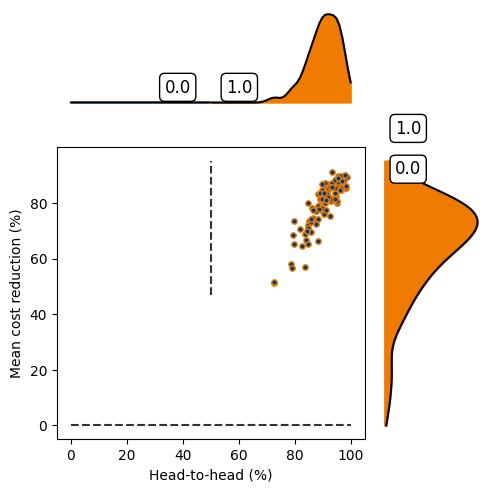

In [110]:
grid = (5,5)
mu = 0.3
lamb = 0.3
file_name = os.path.dirname(grandparent_directory) + middle_path +"DDR_vs_SPO_H2H_Regret_"+str(grid[0])+"times"+str(grid[1])+"_mu="+str(mu)+"_lamb="+str(lamb)
rhf.figure_plot_upright(h2h_ddr_vs_spo_all[grid[0],mu,lamb]*100,regret_reduction_ddr_vs_spo_all[grid[0],mu,lamb]*100,file_name)